# 9.6. Image Detection Exercise: Finding Nemo

**Goal: Building an image classifier**

1.  Chop up the image into slices of 224x224 pixels
2.  Predict labels using a pre-trained network (MobileNet)
3.  Collect labels / predictions for all slices
4.  Filter out predictions that are below a certain probability threshold
5.  Analyze the results

### 1. Chop up the image into slices of 224x224 pixels

In [1]:
# loading the image with keras image 

from tensorflow.keras.preprocessing import image 

img = image.load_img('images/aquarium.jpg')

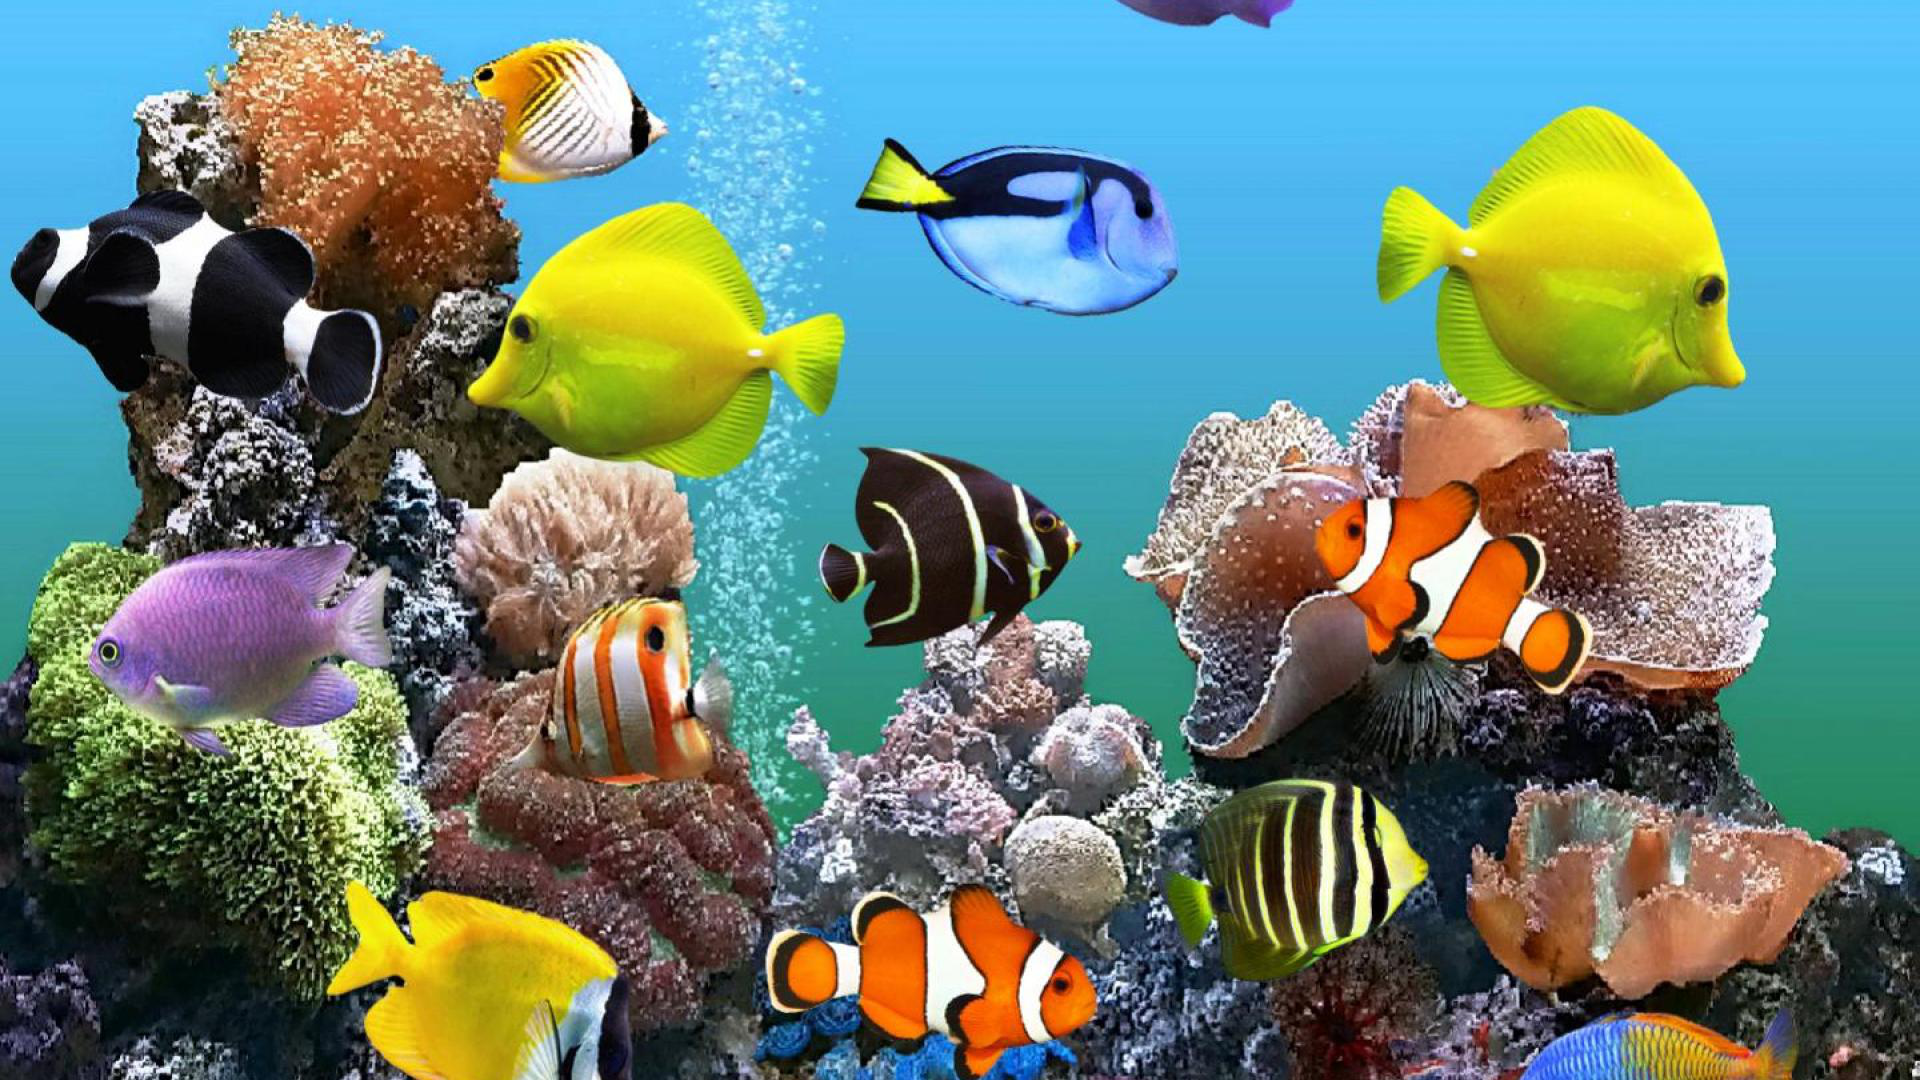

In [2]:
img

In [3]:
# Converting  the image to an array, and checking out some of the properties.
img_array = image.img_to_array(img)

In [4]:
print(img_array.dtype)
print(img_array.shape)
print(img_array.size)

float32
(1080, 1920, 3)
6220800


In [5]:
# Extract a single 1x224x224x3 slice of the image, which are the dimensions of the images from the ImageNet data set
slice = img_array[:224, :224, :]

In [6]:
#to add the extra "1" dimension

import numpy as np
slice = np.expand_dims(slice, axis=0) 


In [7]:
slice.shape

(1, 224, 224, 3)

In [8]:
# normalizing between 0 and 1 (rgb values from 0 to 255)
slice = slice / 255.0

In [9]:
slice.shape

(1, 224, 224, 3)

### 2.1 Predict labels using a pre-trained network (MobileNet)

In [40]:
# Create a prediction from the image slice
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions

model_mobilenet = MobileNetV2(weights='imagenet', include_top=True)

In [11]:
model_mobilenet.compile(optimizer='rmsprop', loss='categorical_crossentropy',
           metrics=['accuracy'])

In [12]:
predictions = model_mobilenet.predict(slice)

2022-03-16 11:30:52.862936: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-03-16 11:30:52.883365: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2699905000 Hz


In [13]:
from pprint import pprint

pprint(decode_predictions(predictions, 10))

[[('n09399592', 'promontory', 0.22282016),
  ('n09246464', 'cliff', 0.12685296),
  ('n03743016', 'megalith', 0.026847383),
  ('n04485082', 'tripod', 0.01961861),
  ('n02841315', 'binoculars', 0.013890517),
  ('n09193705', 'alp', 0.012844236),
  ('n04346328', 'stupa', 0.01280508),
  ('n09428293', 'seashore', 0.011930647),
  ('n09468604', 'valley', 0.011616394),
  ('n03042490', 'cliff_dwelling', 0.010884509)]]


### 2.2. Try another slice to find a fish

In [14]:
slice_2 = img_array[224:448, 224:448, :]
slice_2 = np.expand_dims(slice_2, axis=0)  
slice_2 = slice_2 / 255.0 
slice_2.shape, slice_2.dtype

((1, 224, 224, 3), dtype('float32'))

In [15]:
predictions = model_mobilenet.predict(slice_2)
pprint(decode_predictions(predictions, 10))
decode = decode_predictions(predictions, 10)

[[('n02606052', 'rock_beauty', 0.50572175),
  ('n01930112', 'nematode', 0.06905267),
  ('n04229816', 'ski_mask', 0.028948564),
  ('n02607072', 'anemone_fish', 0.009117499),
  ('n01496331', 'electric_ray', 0.008646266),
  ('n01751748', 'sea_snake', 0.0076609454),
  ('n03929660', 'pick', 0.007337808),
  ('n03992509', "potter's_wheel", 0.006606172),
  ('n02500267', 'indri', 0.0058871782),
  ('n01924916', 'flatworm', 0.00544224)]]


In [16]:
decode[0][0][1]

'rock_beauty'

### 3.  Collect labels / predictions for all slices (Collect multiple slices / "slices" by looping over the image)

In [17]:
img_array.shape

(1080, 1920, 3)

In [53]:
slices = []
s = 224

for x in range(0, 1920-s, 20): # x-axis min, x-axis max, stride size (in pixels) 
    
    for y in range(0, 1080-s, 20):  # y-axis min, y-axis max, stride size (in pixels) 
        
        slice = img_array[x:x+s, y:y+s, :]  # creating a slice with a shape 224, 224, 3
        # slice = slice / 255.0 # normalizing between 0 and 1
        
        if slice.shape == (224, 224, 3): # checking if the shape is correct
            
            slices.append(slice)

In [54]:
# list to array, we created 1849 slices
slices = np.array(slices)
slices.shape

(1849, 224, 224, 3)

### 4. Use the pre-trained model to make predictions on the collected image slices

#### 4.1. MobileNet

In [41]:
decode_predictions

<function tensorflow.python.keras.applications.mobilenet_v2.decode_predictions(preds, top=5)>

In [42]:
predictions_mobilenet = decode_predictions(model_mobilenet.predict(slices))

In [43]:
predictions_mobilenet[0][0][1]

'window_screen'

In [61]:
slices_count = 0
nemo_count = 0

for p in predictions_mobilenet:
    if p[0][1] == 'anemone_fish':
        nemo_count += 1
        print('slice no.', slices_count, p[0])
    slices_count=slices_count+1
print('Finding Nemo on', nemo_count, 'slices')

Finding Nemo on 0 slices


#### 4.2. VGG16

In [45]:
from tensorflow.keras.applications.vgg16 import VGG16, decode_predictions
model_vgg16 = VGG16()

In [46]:
decode_predictions

<function tensorflow.python.keras.applications.vgg16.decode_predictions(preds, top=5)>

In [47]:
model_vgg16.compile(optimizer='rmsprop', loss='categorical_crossentropy',
           metrics=['accuracy'])

In [56]:
predictions_vgg16 = decode_predictions(model_vgg16.predict(slices))

In [57]:
predictions_vgg16[0][0][1]

'black_grouse'

In [60]:
slices_count = 0
nemo_count = 0
accuracy = 0.6


for p in predictions_vgg16:
    if p[0][1] == 'anemone_fish' and p[0][2] > accuracy:
        nemo_count += 1
        print('slice no.', slices_count, p[0])
    slices_count=slices_count+1
print('Finding Nemo on', nemo_count, 'slices with more than', accuracy, 'accuracy score')

slice no. 711 ('n02607072', 'anemone_fish', 0.61968935)
slice no. 725 ('n02607072', 'anemone_fish', 0.6142682)
slice no. 768 ('n02607072', 'anemone_fish', 0.6619207)
slice no. 1841 ('n02607072', 'anemone_fish', 0.621948)
Finding Nemo on 4 slices with more than 0.6 accuracy score
